In [4]:
#Import needed packages

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve
from sklearn import metrics

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold


SMOTE for imbalance

In [5]:
#load preprocessed data
mrna_x = pd.read_csv('processed_mrna_zscore_only.csv')
mrna_x.drop(columns=mrna_x.columns[0], axis=1, inplace=True)
print(mrna_x.shape)

mutation_x = pd.read_csv('processed_mutation_data.csv')
mutation_x.drop(columns=mutation_x.columns[0], axis=1, inplace=True)
print(mutation_x.shape)

meth_x = pd.read_csv('processed_methlyation_data.csv')
meth_x.drop(columns=meth_x.columns[0], axis=1, inplace=True)
meth_x.fillna(0, inplace=True)
print(meth_x.shape)


#mrna_x.drop('target', axis=1, inplace=True)
y = np.load('processed_recurrence_data_zscore_mutation_methlyation.npy')
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(mrna_x.values, y,
                                                    train_size=0.75, test_size=0.25)

age = np.load('age_data_mutation_methylation.npy')
gender = np.load('gender_data_mutation_methlyation.npy')
stage = np.load('stage_data_mutation_methylation.npy')

# Try using lasso (feature selection), feature importance, shap


(210, 19910)
(210, 11390)
(210, 16451)
(210,)


Random Forest Feature Selection for MRNA features

In [25]:
X_train, X_test, y_train, y_test = train_test_split(mrna_x.values, y,
                                                    train_size=0.75, test_size=0.25)

# parameters to be tested on GridSearchCV
# Initializing the Model
lasso = Lasso()

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

filtered_mrna_subset=np.array(mrna_x.columns)[lasso1_coef>0.00001]

print(len(filtered_mrna_subset))

filtered_mrna_x = mrna_x[filtered_mrna_subset]

print(filtered_mrna_subset.size)



1451
1451


c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.690e-03, tolerance: 3.443e-03
  model = cd_fast.enet_coordinate_descent(


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


X_train, X_test, y_train, y_test = train_test_split(filtered_mrna_x.values, y,
                                                    train_size=0.75, test_size=0.25)


params = {'n_estimators': randint(1, 5),
          'max_depth': randint(5, 10)}
rfcv =RandomizedSearchCV(estimator= RandomForestRegressor(random_state=0), n_iter=5, param_distributions=params, random_state=0)
rfcv.fit(X_train, y_train)
print(rfcv.best_params_)

{'max_depth': 5, 'n_estimators': 4}


In [27]:
rf = RandomForestRegressor(random_state=0, max_depth=9, n_estimators=4)
rf.fit(X_train, y_train)




RandomForestRegressor(max_depth=9, n_estimators=4, random_state=0)

In [28]:
rfe = RFECV(rf, cv=5, scoring="neg_mean_squared_error", step=0.05)
rfe.fit(X_train, y_train)
selected_features_mrna = np.array(filtered_mrna_x.columns)[rfe.get_support()]
print("Selected Feature Mutation Feature Columns: {}".format(selected_features_mrna))

Selected Feature Mutation Feature Columns: ['TIMM23' 'RNU12-2P' 'EFCAB8' ... 'ZNF556' 'ZNF717' 'ZNF883']


In [29]:
print(selected_features_mrna.shape)
print(np.array(mrna_x.columns).shape)
rfe.n_features_

(1235,)
(19910,)


1235

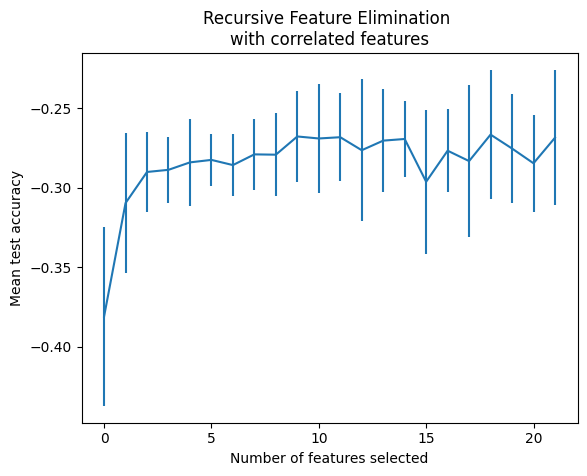

In [30]:
cv_results = pd.DataFrame(rfe.cv_results_)
cv_results.shape
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=range(len(cv_results)),
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [68]:
pd.DataFrame(rfe.cv_results_)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,-0.329146,0.055772,-0.327041,-0.324130,-0.251781,-0.426018,-0.316759
1,-0.349923,0.051684,-0.332465,-0.318359,-0.431452,-0.383065,-0.284274
2,-0.291532,0.060847,-0.208984,-0.353516,-0.241935,-0.364919,-0.288306
3,-0.283833,0.064628,-0.181641,-0.324219,-0.292339,-0.370968,-0.250000
4,-0.296749,0.072995,-0.205078,-0.361328,-0.239919,-0.399194,-0.278226
5,-0.288508,0.061318,-0.189453,-0.341797,-0.284274,-0.362903,-0.264113
6,-0.295640,0.066150,-0.185547,-0.365234,-0.302419,-0.358871,-0.266129
7,-0.310396,0.045175,-0.234375,-0.341797,-0.346774,-0.346774,-0.282258
8,-0.288684,0.062209,-0.193359,-0.310547,-0.302419,-0.381048,-0.256048
9,-0.318397,0.063581,-0.226562,-0.359375,-0.326613,-0.407258,-0.272177


Random Forest Feature Selection for Methylation

In [70]:

X_train, X_test, y_train, y_test = train_test_split(meth_x.values, y,
                                                    train_size=0.75, test_size=0.25)


params = {'n_estimators': randint(1, 5),
          'max_depth': randint(5, 10)}
rfcv_meth =RandomizedSearchCV(estimator= RandomForestRegressor(random_state=0), n_iter=5, param_distributions=params, random_state=0)
rfcv_meth.fit(X_train, y_train)
print(rfcv_meth.best_params_)

ValueError: Found input variables with inconsistent numbers of samples: [210, 500]

In [ ]:
rf_meth = RandomForestRegressor(random_state=0, max_depth=9, n_estimators=4)
rf_meth.fit(X_train, y_train)

rfe_meth = RFECV(rf, cv=5, scoring="neg_mean_squared_error", step=0.05)
rfe_meth.fit(X_train, y_train)
selected_features_meth = np.array(meth_x.columns)[rfe_meth.get_support()]
print("Selected Feature Mutation Feature Columns: {}".format(selected_features_meth))



Selected Feature Mutation Feature Columns: ['MAPK1 Methylation' 'CCNJ Methylation' 'RUNDC1 Methylation' ...
 'AUH Methylation' 'RABGAP1 Methylation' 'MAPKAP1 Methylation']


In [ ]:
print(selected_features_meth.shape)
print(np.array(meth_x.columns).shape)

(5765,)
(16451,)


Lasso Feature Selection for Mutation

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(mutation_x.values, y,
                                                    train_size=0.75, test_size=0.25)

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(mutation_x.values, y)
print("Best Params {}".format(lasso_cv.best_params_))

c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e-02, tolerance: 3.828e-03
  model = cd_fast.enet_coordinate_descent(
c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e-02, tolerance: 3.699e-03
  model = cd_fast.enet_coordinate_descent(
c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-02, tolerance: 3.857e-03
  model = cd_fast.enet_coo

Best Params {'alpha': 1e-05}


c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e-02, tolerance: 4.700e-03
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)




c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e-02, tolerance: 3.511e-03
  model = cd_fast.enet_coordinate_descent(


In [ ]:
feature_subset=np.array(mutation_x.columns)[lasso1_coef>0.01]
print(len(feature_subset))
print(np.array(mutation_x.columns).shape)




197
(11390,)


In [ ]:
print(mrna_x[selected_features_mrna].shape[1]+mutation_x[feature_subset].shape[1] + meth_x[selected_features_meth].shape[1])


8957


In [ ]:
selected_features_x = pd.concat(
    [pd.concat([mrna_x[selected_features_mrna].reset_index(drop=True), mutation_x[feature_subset].reset_index(drop=True)], axis=1).reset_index(drop=True),
     meth_x[selected_features_meth].reset_index(drop=True)], axis=1)  
    
print(selected_features_x.shape)

(210, 8957)


In [ ]:

selected_features_x['Age'] = age
selected_features_x['Gender'] = gender
selected_features_x['Stage'] = stage


X_train_1, X_test_after, y_train_1, y_test_after = train_test_split(selected_features_x.values, y,
                                                    train_size=0.80, test_size=0.20, shuffle=True, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X_train_1, y_train_1,
                                                    train_size=0.75, test_size=0.25, shuffle=True, random_state=123)


In [ ]:
selected_features_x

,LOC645851,RGPD7,HSPB1P1,LOC594835,ANKRD20A20P,TMPRSS11E2,GTPBP6,EFCAB12,A1BG,A1CF,...,FBXO25 Methylation,WHSC1L1 Methylation,HNRNPK Methylation,KIAA1432 Methylation,AUH Methylation,RABGAP1 Methylation,MAPKAP1 Methylation,Age,Gender,Stage
0,0.4779,0.6585,-1.5947,-1.8618,-0.8159,-0.6761,-0.6057,-0.7739,-1.9136,1.2761,...,0.076703,0.182662,0.203466,0.161770,0.071998,0.038556,0.047702,47,0,0
1,0.8493,0.4511,0.7546,-1.8618,-1.2372,-0.4812,-0.1181,0.5197,-0.2303,1.1589,...,0.043147,0.107383,0.088992,0.088157,0.056307,0.038288,0.036510,79,0,0
2,0.7665,-0.3218,-0.7718,-1.2364,0.7826,-0.4873,-0.8332,0.9974,-0.9941,0.9899,...,0.056361,0.108443,0.164716,0.140653,0.065337,0.029315,0.049104,79,0,1
3,1.3887,0.8545,-1.5655,-1.8618,-0.4098,-0.6761,-0.0789,-0.2629,0.0432,1.1604,...,0.039710,0.094104,0.121972,0.104191,0.053501,0.031203,0.033189,68,0,0
4,0.7891,0.5114,-0.7642,-1.8618,-1.2827,-0.4991,-0.6186,-0.8586,-1.0142,1.3285,...,0.052231,0.104573,0.136189,0.064693,0.044280,0.024178,0.029658,34,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,-0.7108,-1.4076,-0.7311,-1.8618,-0.6511,-0.6761,-0.3644,-0.4046,-0.4646,-0.1080,...,0.042175,0.081816,0.056984,0.081787,0.034688,0.019379,0.028280,44,1,3
206,-0.9437,-2.7468,-0.6059,-1.8618,1.3788,-0.4595,-0.0995,0.1856,-0.0684,1.0206,...,0.046846,0.065479,0.081696,0.072501,0.044755,0.030948,0.042153,60,0,3
207,-1.5829,-0.3846,-0.2960,-1.8618,0.1581,-0.6761,-0.0447,1.3012,1.2093,0.3015,...,0.036855,0.060440,0.060251,0.071128,0.058652,0.031719,0.031837,78,0,0
208,-0.3896,1.1191,-0.7324,-1.8618,-0.5371,-0.6761,-1.5128,0.1403,-0.0371,1.3159,...,0.035414,0.057953,0.063107,0.067711,0.041778,0.031135,0.040567,61,0,2


X_train_full, X_test_full, y_train, y_test = train_test_split(mrna_x.values, y,
                                                    train_size=0.75, test_size=0.25, shuffle=True, random_state=123)

In [ ]:
pos_x_train = []
neg_x_train = []
print(type(X_train))
for i in range(len(X_train)):
    if y_train[i] == 1:
        pos_x_train.append(X_train[i])
    else:
        neg_x_train.append(X_train[i])
pos_x_train = np.array(pos_x_train)
neg_x_train = np.array(neg_x_train)


<class 'numpy.ndarray'>


In [ ]:
batches = []
batches_y = []

num_batches = 50

batch_size = 32

c = 0
for i in range(num_batches):
    batch = []
    batch_y = []
    temp = np.random.permutation(len(pos_x_train))[:int(batch_size/2)]
    for t in temp:
        batch.append(pos_x_train[t])
        batch_y.append(1)
    temp = np.random.permutation(len(neg_x_train))[:int(batch_size/2)]
    for t in temp:
        batch.append(neg_x_train[t])
        batch_y.append(0)
    batch = np.array(batch)
    batches.append(batch)
    batch_y = np.array(batch_y)
    batches_y.append(batch_y)



In [ ]:
pos=sum(y)
total = len(y)
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 210
    Positive: 71 (33.81% of total)



In [ ]:
#make and compile the Neural Network model
from sklearn.metrics import f1_score
'''
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(200, input_shape=(20531,),activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(2, activation='softmax')

])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

'''
x = selected_features_x.shape[1]

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(x, input_shape=(x,),activation=tf.nn.relu),
  tf.keras.layers.Dense(int(x/2), activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation='sigmoid')

])

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.BinaryCrossentropy()])

In [ ]:
import keras_tuner as kt

tuner = kt.Hyperband()

In [ ]:
import keras_tuner as kt
model_builder = None
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     )

regulizors 

In [ ]:
weights = {}
num_samples = len(y_train)
pos_count = sum(y_train)
neg_count =  num_samples - pos_count

weights[0] = num_samples / (2 * neg_count)
weights[1] = num_samples / (2 * pos_count)


print(weights, num_samples, pos_count, neg_count)

{0: 0.7682926829268293, 1: 1.4318181818181819} 126 44 82


In [ ]:
#Train the model on the cBioPortal data

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), class_weight = weights, callbacks=[es])

#Validate the model

model.evaluate(X_test, y_test, verbose=2)


Epoch 1/100


4/4 [==============================] - 9s 2s/step - loss: 56.4982 - accuracy: 0.4286 - binary_crossentropy: 60.6304 - val_loss: 10.3421 - val_accuracy: 0.3571 - val_binary_crossentropy: 10.3421
Epoch 2/100
4/4 [==============================] - 3s 757ms/step - loss: 8.8710 - accuracy: 0.5556 - binary_crossentropy: 7.3414 - val_loss: 0.6459 - val_accuracy: 0.5952 - val_binary_crossentropy: 0.6459
Epoch 3/100
4/4 [==============================] - 2s 529ms/step - loss: 2.2817 - accuracy: 0.3968 - binary_crossentropy: 2.8581 - val_loss: 1.1637 - val_accuracy: 0.6429 - val_binary_crossentropy: 1.1637
Epoch 4/100
4/4 [==============================] - 2s 514ms/step - loss: 1.3655 - accuracy: 0.6667 - binary_crossentropy: 0.9840 - val_loss: 1.0002 - val_accuracy: 0.4286 - val_binary_crossentropy: 1.0002
Epoch 5/100
4/4 [==============================] - 2s 650ms/step - loss: 0.8268 - accuracy: 0.5000 - binary_crossentropy: 1.0429 - val_loss: 0.8056 - val_accuracy: 0.5476 - val_

[0.645902693271637, 0.5952380895614624, 0.645902693271637]

In [ ]:
#Train the model on the cBioPortal data
y_prob = model.predict(X_test)
y_pred = 1*(y_prob > 0.5)
f1_score(y_test, y_pred)


3/3 [==============================] - 0s 2ms/step


0.76

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        65
           1       0.83      0.70      0.76        27

    accuracy                           0.87        92
   macro avg       0.86      0.82      0.84        92
weighted avg       0.87      0.87      0.87        92



In [ ]:
#print(model.predict(X_test))
print(X_test)
print(y_test)

[[-3.0863  1.4802  1.8243 ... 70.      0.      3.    ]
 [-3.0863  1.0238  1.1932 ... 44.      1.      3.    ]
 [-3.0863  0.7347  2.354  ... 68.      0.      0.    ]
 ...
 [-3.0863 -1.0506  1.3337 ... 65.      0.      2.    ]
 [-3.0863  1.6955 -0.2368 ... 62.      0.      1.    ]
 [-3.0863 -1.546   0.3521 ... 62.      1.      0.    ]]
[1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0]


In [ ]:
y_prob_tf = model.predict(X_test_after)

2/2 [==============================] - 0s 33ms/step


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 1000, max_iter=2000, class_weight=weights, penalty='l1', solver='liblinear', random_state=123)
lr.fit(X_train, y_train)
print(lr.score(X_test_after, y_test_after))
y_prob_lr = lr.predict_proba(X_test_after)[:,1]

0.6666666666666666


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 15)
rf.fit(X_train, y_train)
print(rf.score(X_test_after, y_test_after))
y_prob_rf = rf.predict_proba(X_test_after)[:,1]

0.8095238095238095


In [ ]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(num_leaves = 3, verbose=0)
lgb.fit(X_train, y_train)
print(lgb.score(X_test_after, y_test_after))
y_prob_lgb = lgb.predict_proba(X_test_after)[:,1]

0.7142857142857143


In [ ]:
from sklearn.svm import SVC
svc = SVC(probability=True, C=1000, kernel='linear')
svc.fit(X_train, y_train)
print(svc.score(X_test_after, y_test_after))
y_prob_svc = svc.predict_proba(X_test_after)[:,1]

0.7142857142857143


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
print(kn.score(X_test_after, y_test_after))
y_prob_kn = kn.predict_proba(X_test_after)[:,1]



0.6428571428571429


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(random_state=123)
adb.fit(X_train, y_train)
print(adb.score(X_test_after, y_test_after))
y_prob_adb = adb.predict_proba(X_test_after)[:,1]

0.7619047619047619


In [ ]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(bnb.score(X_test_after, y_test_after))
y_prob_bnb = bnb.predict_proba(X_test_after)[:,1]


0.6190476190476191


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

sgb = GradientBoostingClassifier(random_state=123, subsample = 0.5)

sgb.fit(X_train, y_train)
print(sgb.score(X_test_after, y_test_after))
y_prob_sgb = sgb.predict_proba(X_test_after)[:,1]

0.8571428571428571


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=123, learning_rate= 'constant', solver= 'lbfgs', activation = 'logistic', alpha = 0.05)

#parameter_space = {
#    'activation': ['relu', 'identity', 'logistic', 'tanh'],
#    'solver': ['lbfgs', 'sgd', 'adam'],
#    'alpha': [0.0001, 0.05, 0.001],
#    'learning_rate': ['constant', 'invscaling', 'adaptive'],
#}

from sklearn.model_selection import GridSearchCV

#clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
#clf.fit(X_train, y_train)

#print('Best parameters found:\n', clf.best_params_)


mlp.fit(X_train, y_train)
print(mlp.score(X_test_after, y_test_after))
y_prob_mlp = mlp.predict_proba(X_test_after)[:,1]

0.7142857142857143


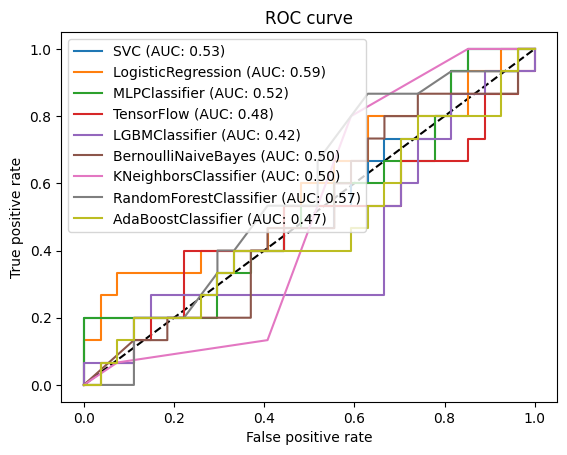

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

fpr, tpr, thresholds = roc_curve(y_test, y_prob_svc)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='SVC (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LogisticRegression (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_mlp)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='MLPClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_tf)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='TensorFlow (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_lgb)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LGBMClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_bnb)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='BernoulliNaiveBayes (AUC: {:.2f})'.format(auc_val))


fpr, tpr, thresholds = roc_curve(y_test, y_prob_kn)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='KNeighborsClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='RandomForestClassifier (AUC: {:.2f})'.format(auc_val))



fpr, tpr, thresholds = roc_curve(y_test, y_prob_adb)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='AdaBoostClassifier (AUC: {:.2f})'.format(auc_val))




plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
'''import shap
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])

shap.initjs()

test = shap_values[:,:,0]

print(shap_values[:,:,0].shape)
shap.force_plot(explainer.expected_value[0], test[0], feature_list)
'''




'import shap\nexplainer = shap.DeepExplainer(model, X_train[:100])\nshap_values = explainer.shap_values(X_test[:10])\n\nshap.initjs()\n\ntest = shap_values[:,:,0]\n\nprint(shap_values[:,:,0].shape)\nshap.force_plot(explainer.expected_value[0], test[0], feature_list)\n'

In [ ]:
feature_list = feature_subset.tolist()
feature_list.append('Age')
feature_list.append('Gender')
feature_list.append('Stage')
feature_list = np.array(feature_list)



In [ ]:
lasso_x

,LOC100130426,UBE2Q2P3,UBE2Q2P3.1,TIMM23,LOC155060,EZHIP,SRP14P1,LOC391343,SPATA31B1P,KIAA1618,...,FAM7A2,FAM83C,FAM90A1,GFRA3,PAX8-AS1,GOLGA2P6,PABPC1L2A,Age,Gender,Stage
0,-3.0863,0.3223,-0.7343,0.1476,0.9885,0.6324,-0.2790,-1.3357,-3.1335,0.2856,...,0.1299,-1.5160,0.6673,1.0047,-0.4075,-0.5411,-1.9193,77,1,2
1,-3.0863,1.4031,1.3759,-1.3732,2.0512,-0.3527,0.4855,-0.1217,-3.1335,-1.1747,...,1.3978,-1.5160,-0.6140,-0.6200,0.8217,-1.8764,-1.9193,57,0,1
2,-3.0863,1.5672,1.6364,0.4353,0.6953,-1.5927,-1.5463,-0.6015,-3.1335,1.3950,...,1.1597,-0.7771,0.8820,1.3079,-0.4106,-0.7665,-1.9193,67,0,1
3,-3.0863,0.9756,1.2166,0.0829,0.2252,-0.8073,-2.1707,1.0787,-3.1335,1.5120,...,1.2274,0.2129,2.3969,1.5250,2.2129,-1.8764,-1.9193,70,0,0
4,-3.0863,1.2136,1.5562,-1.1680,0.5609,-1.5927,-1.6107,-0.6269,-3.1335,1.0482,...,-0.6403,-0.2560,-1.4352,-1.2429,-0.0655,-0.8050,-1.9193,52,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,-3.0863,-0.1792,-0.5201,-0.1529,-1.0120,-1.5927,0.0249,-1.3357,-3.1335,-0.2139,...,-0.5027,-1.5160,0.1051,-0.5190,0.0881,-1.8764,-1.9193,52,1,0
362,-3.0863,0.0395,-1.1065,-1.7599,-0.2565,-0.8109,-0.3949,-1.3357,-3.1335,0.2862,...,-1.3251,-1.5160,-0.8410,0.1365,-0.1071,-1.8764,-1.9193,47,1,0
363,-3.0863,-1.1901,0.5716,0.4635,-1.2582,-0.4238,-0.9779,-0.2021,-3.1335,1.3109,...,1.6851,-0.3752,0.4309,4.6835,-1.1716,-1.8764,-1.9193,67,1,0
364,-1.1093,0.1797,-1.2507,-1.2740,-1.1998,-1.0326,-1.4370,-1.3357,-3.1335,0.8243,...,-0.9469,-0.6027,-0.9150,0.3731,0.4654,-1.8764,-1.9193,55,0,0


In [ ]:
def keras_model(X):
    return model.predict(X, verbose=False).flatten()

In [ ]:
X_test.shape

(92, 213)

In [ ]:
import shap
explainer = shap.KernelExplainer(keras_model, X_test[:10])
shap_values = explainer.shap_values(X_test[10:20])


  0%|          | 0/10 [00:00<?, ?it/s]

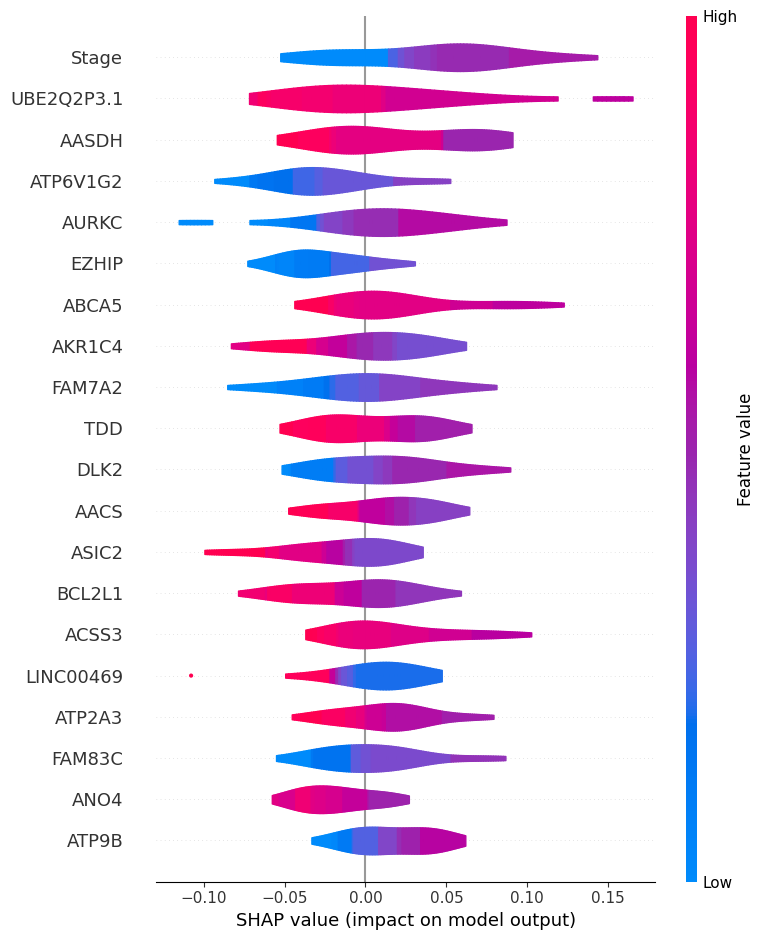

In [ ]:
#shap.initjs()
shap.summary_plot(shap_values,X_test[10:20],feature_names=feature_list, plot_type="violin")
plt.show()


In [ ]:
asbsad

NameError: name 'asbsad' is not defined

In [ ]:
type(explainer)

shap.explainers._kernel.KernelExplainer

In [ ]:
shap.plots.beeswarm(shap_values)

TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values )

In [ ]:
print(shap_values.shape)
print(X_test[:1].shape)

(20, 1307, 1)
(1307,)


In [ ]:
print(shap_values)

[[[ 0.        ]
  [ 0.        ]
  [-0.00406098]
  ...
  [ 0.03611475]
  [ 0.        ]
  [-0.00394583]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.08266036]
  [ 0.00263166]
  [ 0.00645278]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.00245485]
  [ 0.        ]
  [ 0.        ]]

 ...

 [[ 0.00158825]
  [ 0.        ]
  [-0.0070686 ]
  ...
  [ 0.02979047]
  [ 0.        ]
  [-0.00523747]]

 [[ 0.        ]
  [ 0.00416919]
  [-0.00276461]
  ...
  [ 0.06595436]
  [ 0.        ]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [-0.0905685 ]
  [ 0.        ]
  [ 0.00603381]]]


In [ ]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][:,0], X_test.iloc[0,:], link="logit")



c:\Python39\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# train a SVM classifier

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict(X_train), X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][:,0], X_test.iloc[0,:], link="logit")

11/11 [==============================] - 0s 3ms/step
Provided model function fails when applied to the provided data set.


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
print(X_test.shape)
print(shap_values.shape)

(30, 4)
(30, 4, 3)


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)


553467096/553467096 [==============================] - 39s 0us/step


TypeError: Tensors are unhashable (this tensor: KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")). Instead, use tensor.ref() as the key.

In [ ]:
background = X_train[np.random.choice(x_train.shape[0], 100, replace=False)]
